# Bootstrap: Fitting Cosmological Models to Type 1a Supernova Data 
 >__Created__: Fall 2021 for LPC Stats 2021 Harrison B. Prosper<br>


## Introduction
See cosmology introduction in __minuit_example.ipynb__.

### Bootstrap
The bootstrap was introduced by Brad Efron in 1979$^1$. The idea behind the bootstrap is simple: In the absence of any other information, the observed sample of data are the most complete information we have about the population from which the data are presumed to have been sampled. Consequently, if we sample *with replacement* from the sample this is our best approximation to sampling from the population. Given a function $y = f(S)$ of the data sample $S$, we can compute $y^* = f(S^*)$ for every bootstrap sample $S^*$. The distribution of $y^*$, namely $g^*(y^*)$, approximates $g(y)$ of $y$. 

This notebook, illustrates the bootstrap using the Union 2.1 compilation of Type 1a supernovae data.

1. Efron, B. and Tibshirani, R. J. (1993) An Introduction to the Bootstrap. New York: Chapman and Hall.

### Load Type 1a utilities

In [1]:
%run ../type1autil.ipynb

Welcome to JupyROOT 6.24/00


### Read Type 1a supernova data 

### Select data

number of observations: 580
     	         z	         x +/- dx        
    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    

fig_union_2_1_data.pdf


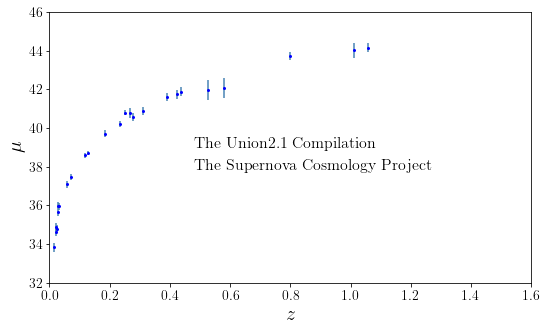

In [2]:
# place results in a bag for later use
class Bag: pass

bag = Bag()

filename = '../SCPUnion2.1_mu_vs_z.txt'

# first randomly shuffle data
Z0, MU0, DMU0 = read_data(filename)
k   = np.arange(len(Z0))
np.random.shuffle(k)

# now select number of data points
Ndata = 25
Z     = Z0[k][:Ndata]
MU    = MU0[k][:Ndata]
DMU   = DMU0[k][:Ndata]

bag.z  = Z
bag.mu = MU
bag.dmu= DMU

plot_data(bag)

### Choose model
   * 'LCDM' or 'phantom'
   * Compile C++ CosmicCode using ROOT

In [3]:
bag.name   = 'phantom'

bag.code, bag.params = compileCode(bag, PARAMS)

# initialize a C array for the parameters; this is needed for
# distanceModulus
bag.p = array('d')


	phantom model



### Function to be minimized modeled as a Python class

The function to be minimized is (within a constant) the negative log-likelihood. Here the errors are assumed to be Gaussian distributed.

In [5]:
def nll(pars, *args):
    bag = args[0]
    
    # put a bound on parameters
    if ((pars <= 0) + (pars >= 200)).any():
        return 1.e10
    
    # copy from numpy array to regular array
    for i, v in enumerate(pars): bag.p[i] = v
   
    f = np.array([bag.code.distanceModulus(u, bag.p) for u in bag.z])      
    c = (bag.mu - f) / bag.dmu
    c = c * c 
    return c.sum()/2
      
# Tell Minuit that the cost function is a negative 
# log-likelihood so that the Hessian is scaled correctly.
nll.errordef = im.Minuit.LIKELIHOOD

### Bootstrap

In [6]:
def bootstrap(bag, nboot=200):
    
    boots = []
    for ii in range(nboot):
        
        # generate a bootstrap sample
        
        k = np.random.choice(len(Z), len(Z))

        bag.z   = Z[k]
        bag.mu  = MU[k]
        bag.dmu = DMU[k]
        
        # initial values of params
        for name, value, _, _ in bag.params:
            bag.p.append(value)
        guess = np.array(bag.p)
        
        # fit
        res = im.minimize(nll, guess, args=(bag,)) 
        x   = res.x
        cov = res.hess_inv
        boots.append((x, cov))
        
        if ii % 5 == 0:
            print('%5d\t%10.3f %10.3f' % (ii, x[0], x[1]))
    return boots

In [7]:
boots = bootstrap(bag, nboot=51)

    0	     2.699     71.370
    5	     1.120     69.281
   10	     3.545     73.151
   15	     1.858     70.838
   20	     1.935     68.319
   25	     2.982     71.375
   30	     1.753     67.696
   35	     2.237     72.502
   40	     3.667     72.969
   45	     1.837     68.112
   50	     2.019     68.540


### Plot Results

In [10]:
NMIN =  0.00
NMAX =  4.00
HMIN = 64.00
HMAX = 78.00

def plot_scatter(boots, ndata,
                 xmin=NMIN, xmax=NMAX, 
                 ymin=HMIN, ymax=HMAX, 
                 ftsize=20, 
                 fgsize=(6, 6)):

    # set size of figure
    fig = plt.figure(figsize=fgsize)

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    # annotate axes
    plt.xlabel(r'$n$', fontsize=ftsize)
    plt.ylabel(r'$H_0$', fontsize=ftsize)
    
    x = [ z[0] for z, c in boots ]
    y = [ z[1] for z, c in boots ]

    c1 = plt.scatter(x, y)
    #c1.collections[0].set_label('true likelihood')

    plt.text(0.2, 75, 'sample size: %d' % ndata)
    # display legends
    #plt.legend(loc='upper right', fontsize=18)
    
    fig.tight_layout()
    filename = 'fig_phantom_bootstrap_%d.pdf' % ndata
    print(filename)
    plt.savefig(filename)
    plt.show()

fig_phantom_bootstrap_25.pdf


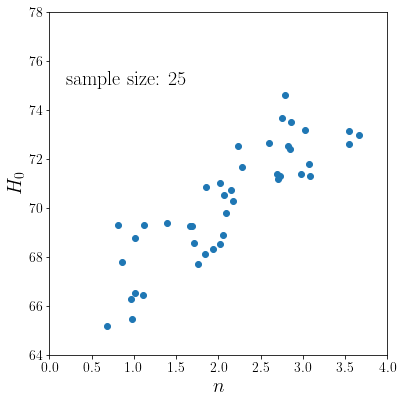

In [11]:
plot_scatter(boots, ndata=Ndata)